# LIME (Local Interpretable Model-agnostic Explanations) Implementation by Hand

This notebook demonstrates a simplified implementation of the LIME algorithm from scratch. LIME is a technique used to explain the predictions of any machine learning model by approximating it locally with an interpretable model.

## What is LIME?

LIME stands for **Local Interpretable Model-agnostic Explanations**. It helps explain individual predictions of black-box machine learning models by learning an interpretable model locally around the prediction.

Key characteristics of LIME:
- **Local**: Focuses on explaining individual predictions rather than the entire model
- **Interpretable**: Uses simple models (like linear regression) that are easy to understand
- **Model-agnostic**: Can be applied to any machine learning model

## How LIME Works

1. Take an instance you want to explain
2. Perturb the instance to create a dataset of similar instances
3. Get predictions from the black-box model for these perturbed instances
4. Weight the perturbed instances based on their proximity to the original instance
5. Train a simple, interpretable model (like linear regression) on this weighted dataset
6. Use the coefficients of this interpretable model to explain the original prediction

Let's implement this step by step!


In [1]:
# Import necessary libraries
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


## Sigmoid Function

We'll use a sigmoid function for our example model. The sigmoid function maps any real value to a value between 0 and 1, making it useful for binary classification problems.

The formula for the sigmoid function is:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

This function has an S-shaped curve and is often used as an activation function in neural networks and logistic regression.


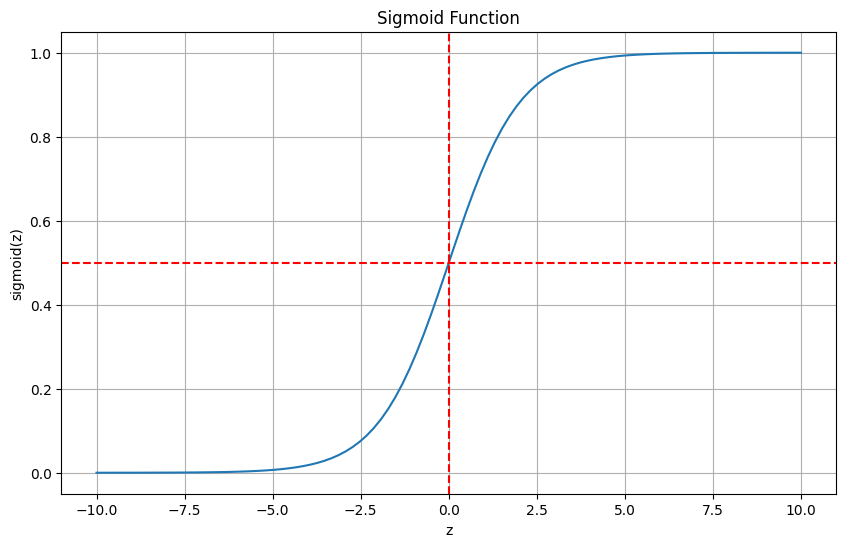

In [2]:
def sigmoid(z):
    """Convert input to a value between 0 and 1 using the sigmoid function"""
    return 1.0 / (1.0 + np.exp(-z))

# Visualize the sigmoid function
z = np.linspace(-10, 10, 100)
y = sigmoid(z)

plt.figure(figsize=(10, 6))
plt.plot(z, y)
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


## Creating a Simple Black-Box Model

For demonstration purposes, we'll create a simple model that takes two input features (x1 and x2) and returns a probability using the sigmoid function. In a real-world scenario, this could be a complex neural network or any other black-box model.

Our model will compute: $z = 1.5 \times x_1 - 1.0 \times x_2$ and then apply the sigmoid function to get the output.

Note that the coefficients (1.5 and -1.0) represent the true importance of each feature. In a real scenario, we wouldn't know these values and would use LIME to approximate them.


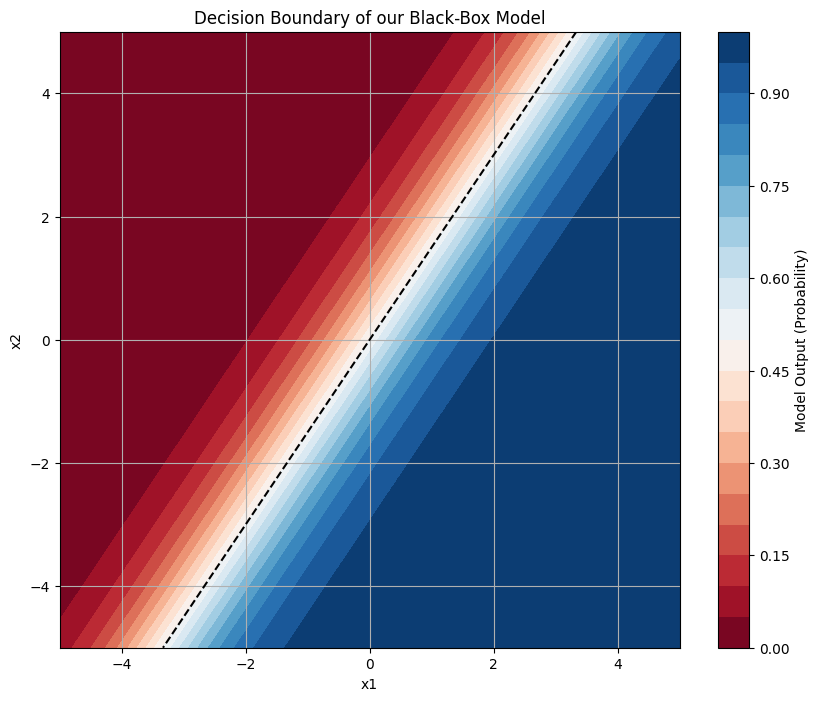

In [4]:
def my_model(x1, x2):
    """A simple model that combines two features and applies sigmoid"""
    z = 1.5 * x1 - 1.0 * x2
    return sigmoid(z)

# Let's visualize our model's decision boundary
x1_range = np.linspace(-5, 5, 100)
x2_range = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.zeros_like(X1)

for i in range(len(x1_range)):
    for j in range(len(x2_range)):
        Z[j, i] = my_model(X1[j, i], X2[j, i])

plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, Z, 20, cmap='RdBu')
plt.colorbar(contour, label='Model Output (Probability)')
plt.title('Decision Boundary of our Black-Box Model')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

# Add the decision boundary line (where output = 0.5)
plt.contour(X1, X2, Z, levels=[0.5], colors='k', linestyles='--')
plt.show()


## LIME Implementation

Now, let's implement the LIME algorithm from scratch. Our `LIMEHandExplainer` class will:

1. Take a black-box model as input
2. Generate perturbed samples around a given instance
3. Get predictions from the black-box model for these samples
4. Weight the samples based on their distance from the original instance
5. Fit a linear model to approximate the black-box model locally
6. Return the coefficients of this linear model as explanations

### Key Parameters:

- **kernel_width**: Controls how quickly the weight decreases as the distance increases. A smaller value means the weight decreases more rapidly.
- **num_samples**: The number of perturbed samples to generate.
- **noise_scale**: Controls how far the perturbed samples can be from the original instance.


In [5]:
class LIMEHandExplainer:
    def __init__(self, model, kernel_width=0.75):
        """Initialize the LIME explainer with a black-box model
        
        Args:
            model: The black-box model to explain
            kernel_width: Parameter controlling the kernel width for the exponential kernel
        """
        self.model = model
        self.kernel_width = kernel_width
        
    def explain_instance(self, x1_0, x2_0, num_samples=10, noise_scale=0.5):
        """Explain a specific instance by approximating the model locally
        
        Args:
            x1_0, x2_0: The instance to explain
            num_samples: Number of perturbed samples to generate
            noise_scale: Scale of the perturbation noise
            
        Returns:
            a0, a1, a2: Intercept and coefficients of the linear model
            linear_model: The fitted linear model
        """
        # Initialize lists to store perturbed samples, predictions, and weights
        x1_vals = []
        x2_vals = []
        f_vals  = []
        weights = []
        
        # Generate perturbed samples
        for _ in range(num_samples):
            # Add random noise to the original instance
            x1_pert = x1_0 + np.random.normal(0, noise_scale)
            x2_pert = x2_0 + np.random.normal(0, noise_scale)
            
            # Get prediction from the black-box model
            y_pred = self.model(x1_pert, x2_pert)
            
            # Calculate distance from the original instance
            dist = np.sqrt((x1_pert - x1_0)**2 + (x2_pert - x2_0)**2)
            
            # Calculate weight using an exponential kernel
            w = np.exp(-dist**2 / self.kernel_width)
            
            # Store the values
            x1_vals.append(x1_pert)
            x2_vals.append(x2_pert)
            f_vals.append(y_pred)
            weights.append(w)
        
        # Prepare data for the linear model
        X = np.column_stack([x1_vals, x2_vals])
        y = np.array(f_vals)
        w = np.array(weights)
        
        # Fit a weighted linear regression model
        linreg = LinearRegression()
        linreg.fit(X, y, sample_weight=w)
        
        # Extract coefficients
        a0 = linreg.intercept_
        a1, a2 = linreg.coef_
        
        return a0, a1, a2, linreg


## Using LIME to Explain a Prediction

Now, let's use our LIME implementation to explain a specific prediction. We'll:

1. Choose an instance to explain (x1=2.0, x2=0.0)
2. Get the black-box model's prediction for this instance
3. Use LIME to explain this prediction
4. Interpret the coefficients of the local linear model

The coefficients will tell us how each feature contributes to the prediction locally. A positive coefficient means increasing that feature increases the prediction, while a negative coefficient means the opposite.


In [6]:
# Create a LIME explainer with our model
explainer = LIMEHandExplainer(model=my_model, kernel_width=0.75)

# Choose an instance to explain
x1_0, x2_0 = 2.0, 0.0

# Get the model's prediction for this instance
y_pred = my_model(x1_0, x2_0)
print(f"Target instance: (x1={x1_0}, x2={x2_0}), model output = {y_pred:.3f}")

# Use LIME to explain this prediction
a0, a1, a2, linear_model = explainer.explain_instance(x1_0, x2_0,
                                                      num_samples=10,
                                                      noise_scale=0.5)

print(f"\nLocal Surrogate Model (LIME):\n"
      f"   y_local = {a0:.3f} + {a1:.3f}*x1 + {a2:.3f}*x2")

print("\nInterpretation:")
print(f" - The coefficient for x1 is {a1:.3f}.")
print(f" - The coefficient for x2 is {a2:.3f}.")


Target instance: (x1=2.0, x2=0.0), model output = 0.953

Local Surrogate Model (LIME):
   y_local = 0.819 + 0.062*x1 + -0.046*x2

Interpretation:
 - The coefficient for x1 is 0.062.
 - The coefficient for x2 is -0.046.


## Visualizing the LIME Explanation

Let's visualize the LIME explanation to better understand how it works. We'll:

1. Plot the perturbed samples and their predictions
2. Show how the weights affect the importance of each sample
3. Visualize the local linear model and compare it to the black-box model
4. Create a bar chart of feature contributions


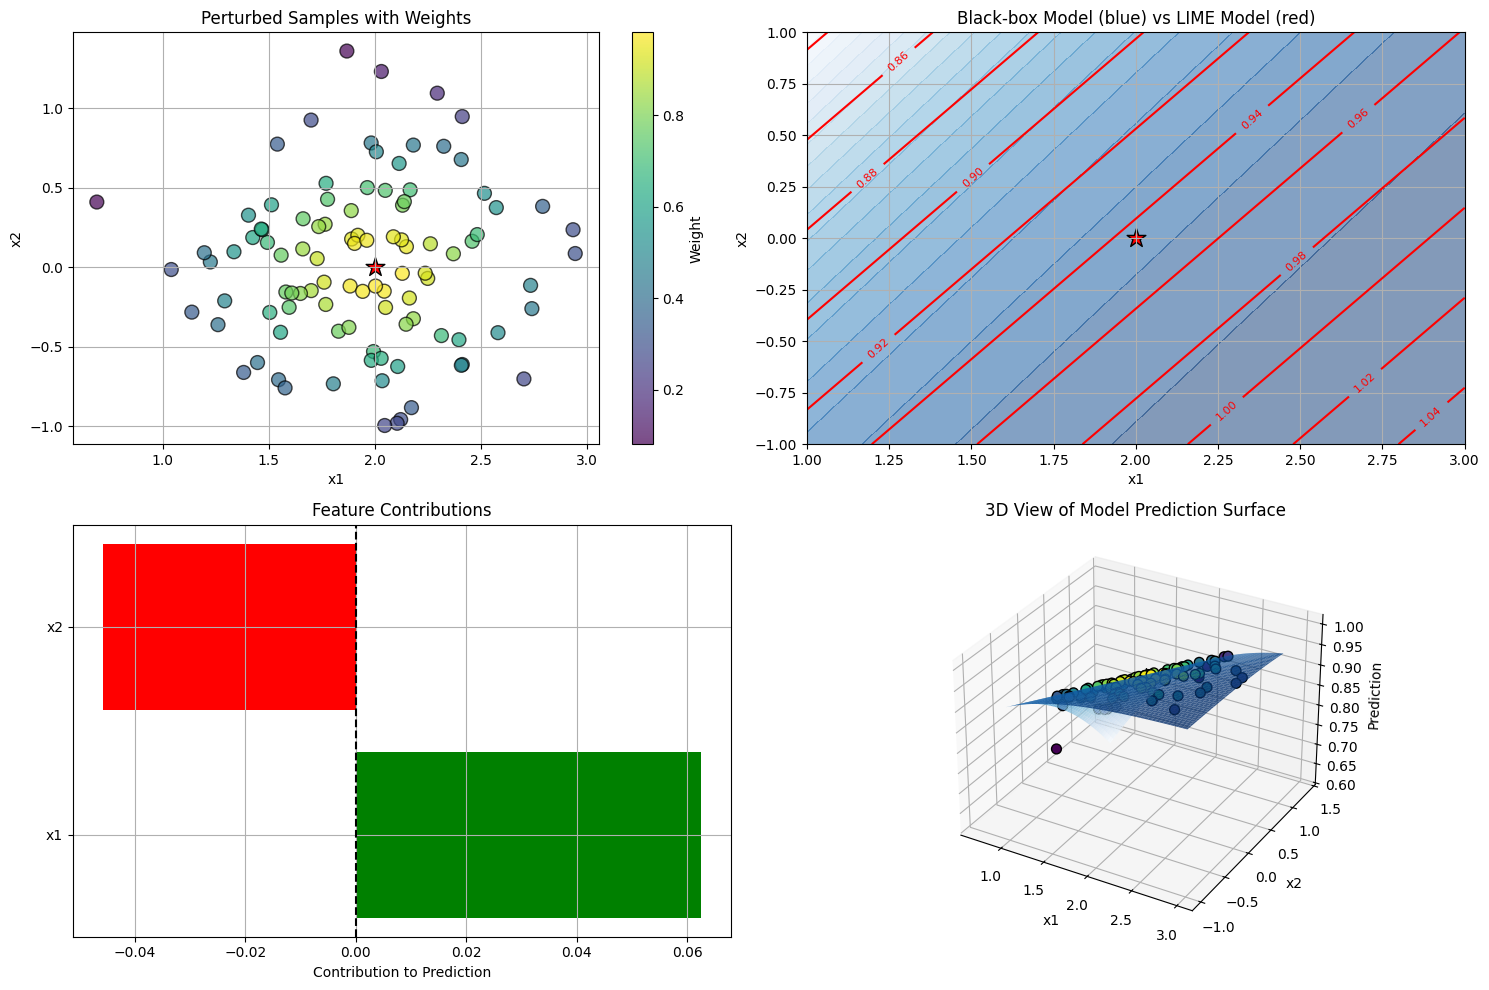

In [7]:
# Generate perturbed samples for visualization
np.random.seed(42)  # For reproducibility
num_vis_samples = 100
x1_samples = []
x2_samples = []
y_samples = []
weights_samples = []

for _ in range(num_vis_samples):
    x1_pert = x1_0 + np.random.normal(0, 0.5)
    x2_pert = x2_0 + np.random.normal(0, 0.5)
    y_pert = my_model(x1_pert, x2_pert)
    dist = np.sqrt((x1_pert - x1_0)**2 + (x2_pert - x2_0)**2)
    weight = np.exp(-dist**2 / 0.75)
    
    x1_samples.append(x1_pert)
    x2_samples.append(x2_pert)
    y_samples.append(y_pert)
    weights_samples.append(weight)

# Convert to numpy arrays
x1_samples = np.array(x1_samples)
x2_samples = np.array(x2_samples)
y_samples = np.array(y_samples)
weights_samples = np.array(weights_samples)

# Create a grid for the linear model
x1_grid = np.linspace(x1_0 - 1, x1_0 + 1, 100)
x2_grid = np.linspace(x2_0 - 1, x2_0 + 1, 100)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)
Z_grid = np.zeros_like(X1_grid)
Z_lime = np.zeros_like(X1_grid)

for i in range(len(x1_grid)):
    for j in range(len(x2_grid)):
        Z_grid[j, i] = my_model(X1_grid[j, i], X2_grid[j, i])
        Z_lime[j, i] = a0 + a1 * X1_grid[j, i] + a2 * X2_grid[j, i]

# Plot the results
plt.figure(figsize=(15, 10))

# Plot 1: Perturbed samples with weights
plt.subplot(2, 2, 1)
scatter = plt.scatter(x1_samples, x2_samples, c=weights_samples, cmap='viridis', 
                     s=100, alpha=0.7, edgecolors='k')
plt.colorbar(scatter, label='Weight')
plt.scatter(x1_0, x2_0, color='red', s=200, marker='*', edgecolors='k')
plt.title('Perturbed Samples with Weights')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

# Plot 2: Black-box model vs LIME model
plt.subplot(2, 2, 2)
contour_bb = plt.contourf(X1_grid, X2_grid, Z_grid, 20, cmap='Blues', alpha=0.5)
contour_lime = plt.contour(X1_grid, X2_grid, Z_lime, 10, colors='red')
plt.clabel(contour_lime, inline=True, fontsize=8)
plt.scatter(x1_0, x2_0, color='red', s=200, marker='*', edgecolors='k')
plt.title('Black-box Model (blue) vs LIME Model (red)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

# Plot 3: Feature contributions
plt.subplot(2, 2, 3)
features = ['x1', 'x2']
contributions = [a1, a2]
colors = ['green' if c > 0 else 'red' for c in contributions]
plt.barh(features, contributions, color=colors)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Feature Contributions')
plt.xlabel('Contribution to Prediction')
plt.grid(True)

# Plot 4: Prediction surface in 3D
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(2, 2, 4, projection='3d')
surf = ax.plot_surface(X1_grid, X2_grid, Z_grid, cmap='Blues', alpha=0.8)
ax.scatter(x1_samples, x2_samples, y_samples, c=weights_samples, cmap='viridis', 
          s=50, alpha=1, edgecolors='k')
ax.scatter(x1_0, x2_0, y_pred, color='red', s=200, marker='*', edgecolors='k')
ax.set_title('3D View of Model Prediction Surface')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Prediction')

plt.tight_layout()
plt.show()


## Experimenting with Different Parameters

Let's experiment with different parameters to see how they affect the LIME explanation:

1. **kernel_width**: Controls how quickly the weight decreases with distance
2. **num_samples**: Number of perturbed samples to generate
3. **noise_scale**: How far the perturbed samples can be from the original instance

We'll see how these parameters affect the stability and accuracy of the explanation.


In [8]:
# Function to run LIME with different parameters and collect results
def run_lime_experiment(kernel_widths, num_samples_list, noise_scales):
    results = []
    
    for kw in kernel_widths:
        for ns in num_samples_list:
            for scale in noise_scales:
                explainer = LIMEHandExplainer(model=my_model, kernel_width=kw)
                a0, a1, a2, _ = explainer.explain_instance(x1_0, x2_0, num_samples=ns, noise_scale=scale)
                results.append({
                    'kernel_width': kw,
                    'num_samples': ns,
                    'noise_scale': scale,
                    'intercept': a0,
                    'coef_x1': a1,
                    'coef_x2': a2
                })
    
    return results

# Define parameter ranges
kernel_widths = [0.1, 0.5, 1.0, 2.0]
num_samples_list = [10, 50, 100]
noise_scales = [0.1, 0.5, 1.0]

# Run the experiment
np.random.seed(42)  # For reproducibility
experiment_results = run_lime_experiment(kernel_widths, num_samples_list, noise_scales)

# Convert results to a DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(experiment_results)

# Display the results
pd.set_option('display.precision', 3)
results_df


,kernel_width,num_samples,noise_scale,intercept,coef_x1,coef_x2
0,0.1,10,0.1,0.816,0.068,-0.044
1,0.1,10,0.5,0.802,0.073,-0.051
2,0.1,10,1.0,0.861,0.044,-0.047
3,0.1,50,0.1,0.813,0.070,-0.046
4,0.1,50,0.5,0.788,0.081,-0.050
5,0.1,50,1.0,0.802,0.073,-0.044
6,0.1,100,0.1,0.815,0.068,-0.046
7,0.1,100,0.5,0.808,0.071,-0.049
8,0.1,100,1.0,0.791,0.079,-0.044
9,0.5,10,0.1,0.801,0.076,-0.047


## Visualizing Parameter Effects

Let's visualize how different parameters affect the LIME explanations:


/tmp/ipykernel_4074184/2810816407.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kw_df = results_df[results_df['num_samples'] == 50][results_df['noise_scale'] == 0.5]
/tmp/ipykernel_4074184/2810816407.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_df = results_df[results_df['kernel_width'] == 0.5][results_df['noise_scale'] == 0.5]
/tmp/ipykernel_4074184/2810816407.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scale_df = results_df[results_df['kernel_width'] == 0.5][results_df['num_samples'] == 50]


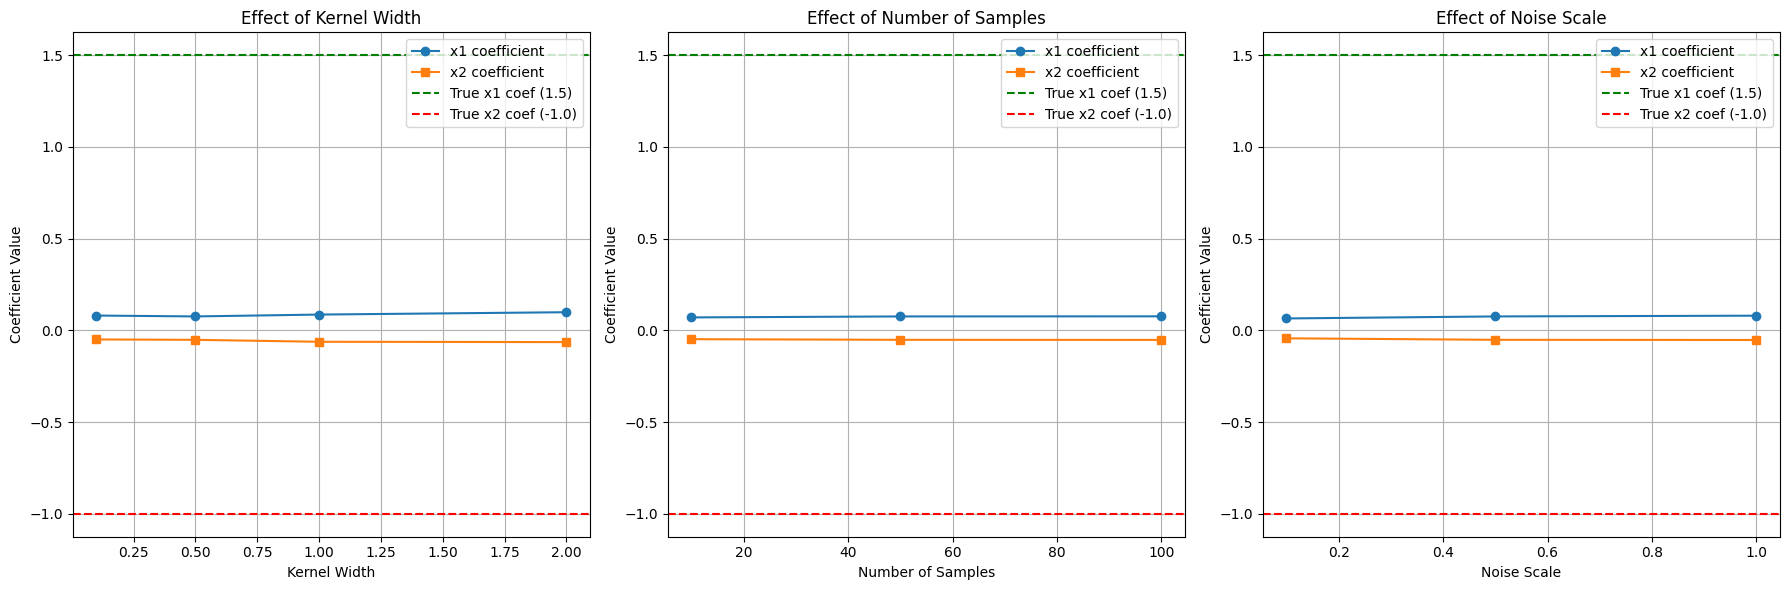

In [9]:
# Plot the effects of different parameters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Effect of kernel_width
kw_df = results_df[results_df['num_samples'] == 50][results_df['noise_scale'] == 0.5]
kw_df = kw_df.sort_values('kernel_width')
axes[0].plot(kw_df['kernel_width'], kw_df['coef_x1'], 'o-', label='x1 coefficient')
axes[0].plot(kw_df['kernel_width'], kw_df['coef_x2'], 's-', label='x2 coefficient')
axes[0].axhline(y=1.5, color='g', linestyle='--', label='True x1 coef (1.5)')
axes[0].axhline(y=-1.0, color='r', linestyle='--', label='True x2 coef (-1.0)')
axes[0].set_xlabel('Kernel Width')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title('Effect of Kernel Width')
axes[0].legend()
axes[0].grid(True)

# Effect of num_samples
ns_df = results_df[results_df['kernel_width'] == 0.5][results_df['noise_scale'] == 0.5]
ns_df = ns_df.sort_values('num_samples')
axes[1].plot(ns_df['num_samples'], ns_df['coef_x1'], 'o-', label='x1 coefficient')
axes[1].plot(ns_df['num_samples'], ns_df['coef_x2'], 's-', label='x2 coefficient')
axes[1].axhline(y=1.5, color='g', linestyle='--', label='True x1 coef (1.5)')
axes[1].axhline(y=-1.0, color='r', linestyle='--', label='True x2 coef (-1.0)')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Coefficient Value')
axes[1].set_title('Effect of Number of Samples')
axes[1].legend()
axes[1].grid(True)

# Effect of noise_scale
scale_df = results_df[results_df['kernel_width'] == 0.5][results_df['num_samples'] == 50]
scale_df = scale_df.sort_values('noise_scale')
axes[2].plot(scale_df['noise_scale'], scale_df['coef_x1'], 'o-', label='x1 coefficient')
axes[2].plot(scale_df['noise_scale'], scale_df['coef_x2'], 's-', label='x2 coefficient')
axes[2].axhline(y=1.5, color='g', linestyle='--', label='True x1 coef (1.5)')
axes[2].axhline(y=-1.0, color='r', linestyle='--', label='True x2 coef (-1.0)')
axes[2].set_xlabel('Noise Scale')
axes[2].set_ylabel('Coefficient Value')
axes[2].set_title('Effect of Noise Scale')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've implemented a simplified version of the LIME algorithm from scratch and used it to explain predictions from a simple black-box model. We've seen how LIME works by:

1. Generating perturbed samples around the instance to explain
2. Getting predictions from the black-box model for these samples
3. Weighting the samples based on their proximity to the original instance
4. Fitting a linear model to approximate the black-box model locally
5. Using the coefficients of this linear model as explanations

We've also explored how different parameters affect the quality of the explanations:

- **kernel_width**: A larger kernel width includes more distant samples in the explanation, potentially making it less local but more stable.
- **num_samples**: More samples generally lead to more stable and accurate explanations, but increase computational cost.
- **noise_scale**: A larger noise scale explores a wider area around the instance, potentially capturing more of the model's behavior but making the explanation less local.

LIME is a powerful technique for explaining individual predictions of complex machine learning models, making them more transparent and trustworthy. By understanding how LIME works, we can better interpret and communicate the decisions made by our models.